In [89]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
total = 22606

# FUNCTIONS
#### String to date time:
Transform files to desirable format
#### Join times:
Combine the overlaped intervals from the two different sources
#### Total alert time:
Computes the total amount of minutes pertaining to the time intervals
#### Roc values:
Returns list with ROC parameteres + Youden

In [116]:
def strings_to_datetime(df):
    df['hora inici'] = (pd.to_datetime(df['dia'] + ' ' + df['hora inici']))
    df['hora final'] = (pd.to_datetime(df['dia'] + ' ' + df['hora final']))
    df['dia'] = (pd.to_datetime(df['dia'])).dt.date

    return df

def join_times(x):
    startdf = pd.DataFrame({'time':x['hora inici'], 'what':1})
    enddf = pd.DataFrame({'time':x['hora final'], 'what':-1})
    mergdf = pd.concat([startdf, enddf]).sort_values(['time', 'what'], ascending=[True, False])
    mergdf['running'] = mergdf['what'].cumsum()
    mergdf['newwin'] = mergdf['running'].eq(1) & mergdf['what'].eq(1)
    mergdf['group'] = mergdf['newwin'].cumsum()
    x['group'] = mergdf['group'].loc[mergdf['what'].eq(1)]
    grouped_df = x.groupby('group')
    combined = pd.DataFrame()
    combined = grouped_df.max()
    combined['hora inici'] = grouped_df['hora inici'].min()
    combined['metode'] = grouped_df['metode'].mean()
    return combined

def total_alert_time(x):
    total_time = ((x['hora final'] - x['hora inici'])/np.timedelta64(1,'m')).sum()
    return total_time

def roc_values_min(x):
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    true_positives = len(true_x) #events
    false_positives_min = total_alert_time(false_x) #minutes
    false_positives_event = len(false_x) #events
    true_negatives = 22606 - total_alert_time(x) #minutes
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives_min/(false_positives_min + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives_min)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives_event, false_positives_min, TPR, FPR, youden]

def roc_values_event_16(x):
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    true_positives = len(true_x)
    false_positives = len(false_x)
    true_negatives = (22606 - total_alert_time(x))/16
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives/(false_positives + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives, true_negatives, TPR, FPR, youden]

def roc_values_event_mean(x):
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    mean_duration = total_alert_time(x)/len(x)
    true_positives = len(true_x)
    false_positives = len(false_x)
    true_negatives = (22606 - total_alert_time(x))/mean_duration
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives/(false_positives + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives, true_negatives, TPR, FPR, youden]

    

#### Read files
* Intervals1: data from the morphological approach
* Intervals2: data from the derivative approach

In [3]:
alba = pd.DataFrame(columns=['TP', 'FP events','FP minutes'])
deltas = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for delta in deltas:
    file2 = f'intervals_collections/intervals_alba/alba-{delta}.csv'
    Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
    Intervals2['metode'] = 2
    strings_to_datetime(Intervals2)
    alba.loc[len(alba)] =roc_values_min(Intervals2)[0:3]
alba

,TP,FP events,FP minutes
0,33.0,446.0,7532.0
1,30.0,298.0,2981.0
2,28.0,162.0,1217.0
3,26.0,84.0,578.0
4,21.0,50.0,348.0
5,20.0,28.0,171.0
6,17.0,18.0,143.0
7,15.0,8.0,90.0
8,12.0,6.0,82.0


In [4]:
alba = pd.DataFrame(columns=['Cond', 'Minutes','Mean duration', '16 min duration'])
deltas = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for delta in deltas:
    file2 = f'intervals_collections/intervals_alba/alba-{delta}.csv'
    Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
    Intervals2['metode'] = 2
    strings_to_datetime(Intervals2)
    alba.loc[len(alba)] = [delta, roc_values_min(Intervals2)[5], roc_values_event_mean(Intervals2)[5], roc_values_event_16(Intervals2)[5]]
alba

,Cond,Minutes,Mean duration,16 min duration
0,0.2,0.642151,0.614929,0.654464
1,0.3,0.772679,0.756719,0.707399
2,0.4,0.793352,0.781757,0.737947
3,0.5,0.761839,0.754190,0.729350
4,0.6,0.620759,0.615846,0.601203
5,0.7,0.598410,0.594981,0.586262
6,0.8,0.508768,0.507221,0.502379
7,0.9,0.450533,0.450437,0.448849
8,1.0,0.359987,0.360401,0.359367


In [5]:
anna = pd.DataFrame(columns=['Cond', 'Minutes','Mean duration', '16 min duration'])
for corr in np.arange(0.977, 0.994, 0.001):
    file1 = f'intervals_collections/intervals_anna/intervals-{corr}.csv'
    Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
    Intervals1['metode'] = 1
    strings_to_datetime(Intervals1)
    anna.loc[len(anna)] = [corr, roc_values_min(Intervals1)[5], roc_values_event_mean(Intervals1)[5], roc_values_event_16(Intervals1)[5]]
anna

,Cond,Minutes,Mean duration,16 min duration
0,0.977,0.603604,0.594837,0.720286
1,0.978,0.577112,0.569338,0.687632
2,0.979,0.613005,0.607135,0.707204
3,0.980,0.641786,0.635426,0.726226
4,0.981,0.656167,0.650858,0.724185
5,0.982,0.668745,0.664093,0.727211
6,0.983,0.682350,0.680974,0.726318
7,0.984,0.724599,0.723724,0.751711
8,0.985,0.775315,0.775297,0.781475
9,0.986,0.657969,0.660733,0.650852


In [6]:
anna = pd.DataFrame(columns=['TP', 'FP events','FP minutes'])
for corr in np.arange(0.977, 0.994, 0.001):
    file1 = f'intervals_collections/intervals_anna/intervals-{corr}.csv'
    Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
    Intervals1['metode'] = 1
    strings_to_datetime(Intervals1)
    anna.loc[len(anna)] =roc_values_min(Intervals1)[0:3]
anna

,TP,FP events,FP minutes
0,33.0,313.0,8469.0
1,31.0,288.0,7780.0
2,31.0,275.0,7050.0
3,31.0,257.0,6431.0
4,30.0,230.0,5492.0
5,29.0,192.0,4572.0
6,28.0,159.0,3642.0
7,28.0,129.0,2724.0
8,28.0,92.0,1618.0
9,23.0,65.0,873.0


Join the two sets of data and create a DataFrame with merged overlapping intervals

# RESULTS
* ### Combined DataFrame

In [7]:
merged = pd.merge_ordered(Intervals1, Intervals2,
              on=['dia', 'hora inici', 'hora final', 'resultat', 'metode'])
combined = join_times(merged)
combined

,dia,hora inici,hora final,resultat,metode
group,,,,,
1,2001-04-15,2001-04-15 13:42:00,2001-04-15 14:06:00,VERDADERO,2.0
2,2001-04-26,2001-04-26 13:02:30,2001-04-26 13:10:00,VERDADERO,1.5
3,2001-12-13,2001-12-13 14:24:00,2001-12-13 14:29:00,VERDADERO,2.0
4,2004-07-16,2004-07-16 13:50:00,2004-07-16 14:01:00,VERDADERO,2.0
5,2004-07-20,2004-07-20 12:25:00,2004-07-20 12:31:00,VERDADERO,2.0
6,2004-08-14,2004-08-14 09:42:00,2004-08-14 09:47:00,FALSO,2.0
7,2004-08-14,2004-08-14 11:34:00,2004-08-14 11:35:00,FALSO,2.0
8,2004-08-15,2004-08-15 12:37:00,2004-08-15 12:39:00,VERDADERO,2.0
9,2005-09-09,2005-09-09 09:53:00,2005-09-09 10:05:00,VERDADERO,2.0


* ### Amount of TP and FP for each method

In [8]:

print('Combined TP:', len(combined[combined['resultat'] == 'VERDADERO']))
print('Combined FP: ',len(combined[combined['resultat'] == 'FALSO']))
print('Anna TP: ', len(Intervals1[Intervals1['resultat'] == 'VERDADERO']))
print('Anna FP: ', len(Intervals1[Intervals1['resultat'] == 'FALSO']))
print('Alba TP: ', len(Intervals2[Intervals2['resultat'] == 'VERDADERO']))
print('Alba FP: ', len(Intervals2[Intervals2['resultat'] == 'FALSO']))
print(total_alert_time(combined))

Combined TP: 16
Combined FP:  7
Anna TP:  5
Anna FP:  1
Alba TP:  12
Alba FP:  6
256.5


In [9]:
combined[combined['resultat'] == 'VERDADERO']

,dia,hora inici,hora final,resultat,metode
group,,,,,
1,2001-04-15,2001-04-15 13:42:00,2001-04-15 14:06:00,VERDADERO,2.0
2,2001-04-26,2001-04-26 13:02:30,2001-04-26 13:10:00,VERDADERO,1.5
3,2001-12-13,2001-12-13 14:24:00,2001-12-13 14:29:00,VERDADERO,2.0
4,2004-07-16,2004-07-16 13:50:00,2004-07-16 14:01:00,VERDADERO,2.0
5,2004-07-20,2004-07-20 12:25:00,2004-07-20 12:31:00,VERDADERO,2.0
8,2004-08-15,2004-08-15 12:37:00,2004-08-15 12:39:00,VERDADERO,2.0
9,2005-09-09,2005-09-09 09:53:00,2005-09-09 10:05:00,VERDADERO,2.0
13,2006-12-05,2006-12-05 10:24:00,2006-12-05 10:55:00,VERDADERO,2.0
14,2011-08-09,2011-08-09 08:00:00,2011-08-09 08:14:00,VERDADERO,2.0


In [10]:
combined

,dia,hora inici,hora final,resultat,metode
group,,,,,
1,2001-04-15,2001-04-15 13:42:00,2001-04-15 14:06:00,VERDADERO,2.0
2,2001-04-26,2001-04-26 13:02:30,2001-04-26 13:10:00,VERDADERO,1.5
3,2001-12-13,2001-12-13 14:24:00,2001-12-13 14:29:00,VERDADERO,2.0
4,2004-07-16,2004-07-16 13:50:00,2004-07-16 14:01:00,VERDADERO,2.0
5,2004-07-20,2004-07-20 12:25:00,2004-07-20 12:31:00,VERDADERO,2.0
6,2004-08-14,2004-08-14 09:42:00,2004-08-14 09:47:00,FALSO,2.0
7,2004-08-14,2004-08-14 11:34:00,2004-08-14 11:35:00,FALSO,2.0
8,2004-08-15,2004-08-15 12:37:00,2004-08-15 12:39:00,VERDADERO,2.0
9,2005-09-09,2005-09-09 09:53:00,2005-09-09 10:05:00,VERDADERO,2.0


In [11]:
def margin(x):
    x['diff'] = ((x['hora inici'] - x['hora final'].shift(1))/np.timedelta64(1, 'm')) > 2
    x['group 2'] = x['diff'].cumsum()
    grouped_df = x.groupby('group 2')
    x = pd.DataFrame()
    x = grouped_df.max()
    x['hora inici'] = grouped_df['hora inici'].min()
    x['metode'] = grouped_df['metode'].mean()
    grouped_df = x.groupby('group 2')
    final = pd.DataFrame()
    final = grouped_df.max()
    final['hora inici'] = grouped_df['hora inici'].min()
    final['metode'] = grouped_df['metode'].mean()
    return final

In [117]:
file1 = 'intervals_collections/intervals_anna/intervals-0.986.csv'
Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
Intervals1['metode'] = 1
strings_to_datetime(Intervals1)
file2 = 'intervals_collections/intervals_alba/alba-0.7.csv'
Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
Intervals2['metode'] = 2
strings_to_datetime(Intervals2)
merged = pd.merge_ordered(Intervals1, Intervals2,
              on=['dia', 'hora inici', 'hora final', 'resultat', 'metode'])
combined = join_times(merged)


In [35]:
final = margin(combined)
final['dia'] = final['hora final'] - final['hora inici']


In [119]:
youden_matrix = pd.DataFrame({})

for corr in np.arange(0.977, 0.994, 0.001):
    file1 = f'intervals_collections/intervals_anna/intervals-{corr}.csv'
    Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
    Intervals1['metode'] = 1
    strings_to_datetime(Intervals1)

    for delta in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        file2 = f'intervals_collections/intervals_alba/alba-{delta}.csv'
        Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
        Intervals2['metode'] = 2
        strings_to_datetime(Intervals2)
        
        merged = pd.merge_ordered(Intervals1, Intervals2,
              on=['dia', 'hora inici', 'hora final', 'resultat', 'metode'])
        combined = join_times(merged)
        combined['dia'] = combined['hora final'] - combined['hora inici']
        final = margin(combined)

        youden_matrix.loc[corr, delta] = roc_values_min(final)[5]

In [120]:
youden_matrix

,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.977,0.440085,0.559809,0.590824,0.599734,0.602545,0.605767,0.601108,0.602491,0.602604
0.978,0.459173,0.557306,0.593176,0.603272,0.606165,0.610241,0.605353,0.606717,0.606869
0.979,0.480794,0.587452,0.626559,0.637771,0.641929,0.646190,0.641086,0.642617,0.642763
0.980,0.495139,0.608165,0.650659,0.663782,0.668404,0.673206,0.669105,0.670635,0.670776
0.981,0.516810,0.642685,0.691251,0.706049,0.712096,0.717458,0.713350,0.714905,0.684760
0.982,0.547308,0.681100,0.762781,0.748063,0.754242,0.759620,0.756236,0.757815,0.727657
0.983,0.570506,0.682595,0.769785,0.757883,0.764566,0.770249,0.768765,0.770543,0.740459
0.984,0.589934,0.714414,0.807580,0.797945,0.805314,0.810180,0.810261,0.812156,0.782100
0.985,0.641244,0.752468,0.882700,0.876969,0.854931,0.891312,0.861218,0.862993,0.832989
0.986,0.656067,0.774286,0.909954,0.936826,0.916385,0.954679,0.894433,0.896536,0.836299


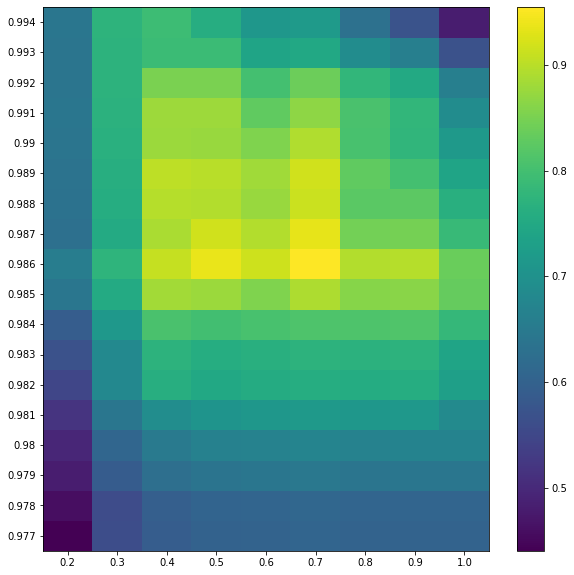

In [121]:
plt.pcolor(youden_matrix)
plt.yticks(np.arange(0.5, len(youden_matrix.index), 1), youden_matrix.index)
plt.xticks(np.arange(0.5, len(youden_matrix.columns), 1), youden_matrix.columns)
plt.colorbar()
plt.show()

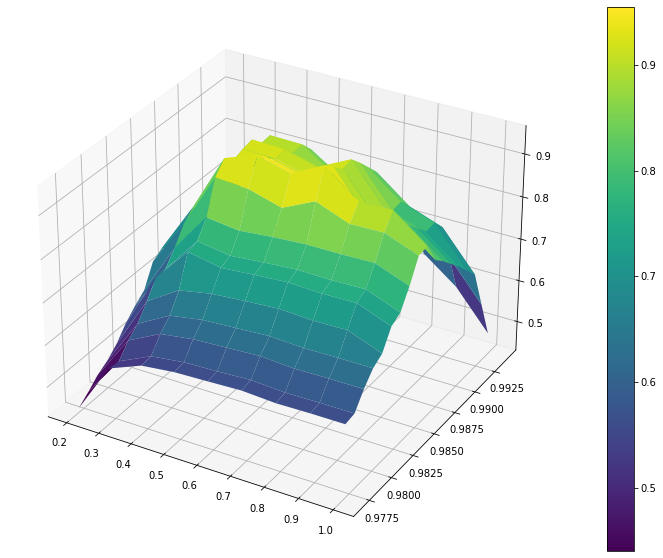

In [157]:
youden_array = youden_matrix.to_numpy()

d,y = np.meshgrid(np.arange(0.2, 1.1, 0.1),np.arange(0.977, 0.994, 0.001))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(d, y, youden_array, rstride=1, cmap=cm.viridis, cstride=1, linewidth=1, antialiased=True)

plt.rcParams['figure.figsize'] = [20, 10]

m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(youden_array)
plt.colorbar(m)

plt.show()